<a href="https://colab.research.google.com/github/amjadvkthai/amjadvkthai/blob/main/AI_DAMAGE_DETECTION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

loading Roboflow workspace...
loading Roboflow project...
loading Roboflow workspace...
loading Roboflow project...


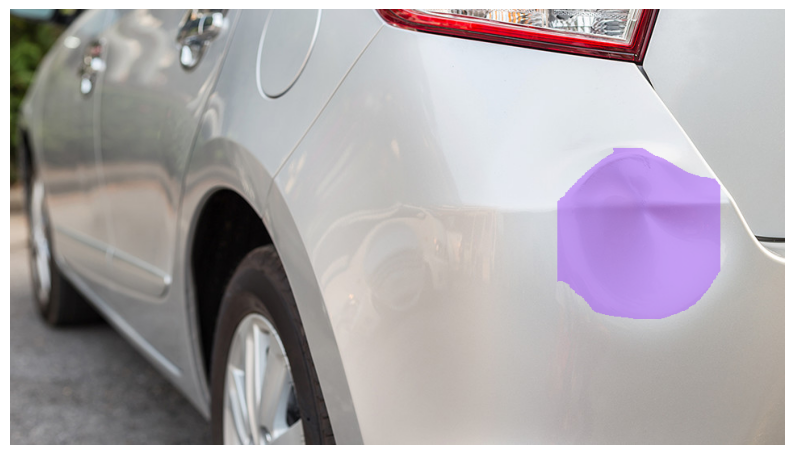

In [13]:
from roboflow import Roboflow
import supervision as sv
import cv2
import tempfile
import os

# Load the Roboflow API and authenticate with your API key
rf = Roboflow(api_key="Y8pFek6CkLT9YHxIxWHv")

# Load the project for identifying parts of the car
project_parts = rf.workspace().project("car-parts-segmentation")
model_parts = project_parts.version(2).model

# Load the project for detecting damaged areas of the car
project_damage = rf.workspace().project("car-damage-detection-ha5mm")
model_damage = project_damage.version(1).model

# Path to the input image
img_path = "/content/car3.jpeg"

# Run the models on the input image
result_damage = model_damage.predict(img_path, confidence=40).json()

# Extract labels and detections from the results
labels_damage = [item["class"] for item in result_damage["predictions"]]
detections_damage = sv.Detections.from_inference(result_damage)

# Extract coordinates of the damaged area
coordinates = []
for List_Coordinates in detections_damage.xyxy:
    for item in List_Coordinates:
        item = int(item)  # Convert to integer
        coordinates.append(item)

# Unpack coordinates
x1, y1, x2, y2 = coordinates


# Initialize label and mask annotators
label_annotator = sv.LabelAnnotator(text_scale=0.15)
mask_annotator = sv.MaskAnnotator()

# Read the input image
image = cv2.imread(img_path)

# Annotate damaged areas of the car
annotated_image_damage = mask_annotator.annotate(
    scene=image, detections=detections_damage)

# Display the annotated damaged areas image
sv.plot_image(image=annotated_image_damage, size=(10, 10))

In [41]:
# BLACK AND WHITE WORKING CODE
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing import image
from skimage.metrics import structural_similarity as ssim

class TruckConditionAnalyzer:
    def __init__(self):
        # Load pre-trained object detection model
        self.base_model = VGG16(weights='imagenet', include_top=False)

    def preprocess_image(self, img_path):
        """Preprocess image for analysis"""
        img = image.load_img(img_path, target_size=(224, 224))
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        return img_array / 255.0

    def extract_features(self, img):
        """Extract deep features from image"""
        features = self.base_model.predict(img)
        return features.flatten()

    def detect_damages(self, pre_departure_img, return_img):
        """Detect potential damages between two truck images"""
        # Preprocess images
        pre_img = self.preprocess_image(pre_departure_img)
        return_img_preprocessed = self.preprocess_image(return_img)  # Use a different variable name

        # Extract features
        pre_features = self.extract_features(pre_img)
        return_features = self.extract_features(return_img_preprocessed)

        # Load original images for detailed analysis
        print(f"Loading pre-departure image from: {pre_departure_img}")
        original_pre = cv2.imread(pre_departure_img)
        print(f"Loading return image from: {return_img}")
        original_return = cv2.imread(return_img)

        # Check if images are loaded correctly
        if original_pre is None:
            raise ValueError(f"Failed to load pre-departure image from {pre_departure_img}")
        if original_return is None:
            raise ValueError(f"Failed to load return image from {return_img}")

        # Resize images to the same dimensions
        height, width = original_pre.shape[:2]
        original_return = cv2.resize(original_return, (width, height))

        # Convert to grayscale for structural comparison
        gray_pre = cv2.cvtColor(original_pre, cv2.COLOR_BGR2GRAY)
        gray_return = cv2.cvtColor(original_return, cv2.COLOR_BGR2GRAY)

        # Compute structural similarity
        score, diff_map = ssim(gray_pre, gray_return, full=True)
        diff_map = (diff_map * 255).astype("uint8")

        # Threshold the difference map
        thresh = cv2.threshold(diff_map, 0, 255,
                               cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]

        # Find contours of potential damage areas
        contours, _ = cv2.findContours(thresh,
                                       cv2.RETR_EXTERNAL,
                                       cv2.CHAIN_APPROX_SIMPLE)

        # Analyze damage severity
        damage_report = {
            'similarity_score': score,
            'potential_damage_areas': len(contours),
            'feature_difference': np.linalg.norm(pre_features - return_features)
        }

        return damage_report

    def generate_damage_visualization(self, pre_departure_img, return_img):
        """Create visualization of detected differences"""
        original_pre = cv2.imread(pre_departure_img)
        original_return = cv2.imread(return_img)

        # Check if images are loaded correctly
        if original_pre is None:
            raise ValueError(f"Failed to load pre-departure image from {pre_departure_img}")
        if original_return is None:
            raise ValueError(f"Failed to load return image from {return_img}")

        # Resize images to the same dimensions
        height, width = original_pre.shape[:2]
        original_return = cv2.resize(original_return, (width, height))

        # Compute absolute difference
        diff = cv2.absdiff(original_pre, original_return)

        # Convert difference to grayscale
        gray_diff = cv2.cvtColor(diff, cv2.COLOR_BGR2GRAY)

        # Apply threshold
        thresh = cv2.threshold(gray_diff, 30, 255, cv2.THRESH_BINARY)[1]

        # Save difference visualization
        cv2.imwrite('damage_difference.png', thresh)

        return 'damage_difference.png'

# Example usage
def main():
    analyzer = TruckConditionAnalyzer()

    # Paths to pre-departure and return images
    pre_departure_img = '/content/bcar.jpg'  # Update with the correct path
    return_img = '/content/acar.jpg'  # Update with the correct path

    # Detect damages
    damage_report = analyzer.detect_damages(pre_departure_img, return_img)
    print("Damage Analysis Report:")
    print(f"Similarity Score: {damage_report['similarity_score']}")
    print(f"Potential Damage Areas: {damage_report['potential_damage_areas']}")

    # Generate damage visualization
    diff_image = analyzer.generate_damage_visualization(pre_departure_img, return_img)
    print(f"Damage visualization saved: {diff_image}")

if __name__ == "__main__":
    main()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 727ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step
Loading pre-departure image from: /content/bcar.jpg
Loading return image from: /content/acar.jpg
Damage Analysis Report:
Similarity Score: 0.8548996827180151
Potential Damage Areas: 224
Damage visualization saved: damage_difference.png


In [40]:
import cv2
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing import image
from skimage.metrics import structural_similarity as ssim

class TruckConditionAnalyzer:
    def __init__(self):
        # Load pre-trained object detection model
        self.base_model = VGG16(weights='imagenet', include_top=False)

        # Load DeepLabV3 model for background removal
        self.segmentation_model = hub.load("https://tfhub.dev/tensorflow/deeplabv3/1")

    def preprocess_image(self, img_path):
        """Preprocess image for analysis"""
        img = image.load_img(img_path, target_size=(224, 224))
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        return img_array / 255.0

    def extract_features(self, img):
        """Extract deep features from image"""
        features = self.base_model.predict(img)
        return features.flatten()

    def remove_background(self, img_path):
        """Remove background from the image using DeepLabV3"""
        # Load image
        img = cv2.imread(img_path)
        if img is None:
            raise ValueError(f"Failed to load image from {img_path}")

        # Resize image to the required input size for DeepLabV3
        resized_img = cv2.resize(img, (513, 513))
        input_img = tf.image.convert_image_dtype(resized_img, tf.float32)[tf.newaxis, ...]

        # Perform segmentation
        results = self.segmentation_model(input_img)
        segmentation_mask = results['default'][0].numpy().argmax(axis=-1)

        # Create a mask for the vehicle (assuming the vehicle is labeled as "car" or "truck")
        vehicle_mask = (segmentation_mask == 2) | (segmentation_mask == 7)  # Adjust based on the model's labels

        # Resize mask to original image size
        vehicle_mask = cv2.resize(vehicle_mask.astype(np.uint8), (img.shape[1], img.shape[0]))

        # Apply mask to the original image
        vehicle_only = cv2.bitwise_and(img, img, mask=vehicle_mask)

        return vehicle_only

    def detect_damages(self, pre_departure_img, return_img):
        """Detect potential damages between two truck images"""
        # Remove background from images
        pre_img_no_bg = self.remove_background(pre_departure_img)
        return_img_no_bg = self.remove_background(return_img)

        # Save the background-removed images for debugging
        cv2.imwrite('pre_departure_no_bg.png', pre_img_no_bg)
        cv2.imwrite('return_no_bg.png', return_img_no_bg)

        # Preprocess images for feature extraction
        pre_img = cv2.resize(pre_img_no_bg, (224, 224))
        pre_img = image.img_to_array(pre_img) / 255.0
        pre_img = np.expand_dims(pre_img, axis=0)

        return_img_preprocessed = cv2.resize(return_img_no_bg, (224, 224))
        return_img_preprocessed = image.img_to_array(return_img_preprocessed) / 255.0
        return_img_preprocessed = np.expand_dims(return_img_preprocessed, axis=0)

        # Extract features
        pre_features = self.extract_features(pre_img)
        return_features = self.extract_features(return_img_preprocessed)

        # Convert images to grayscale for structural comparison
        gray_pre = cv2.cvtColor(pre_img_no_bg, cv2.COLOR_BGR2GRAY)
        gray_return = cv2.cvtColor(return_img_no_bg, cv2.COLOR_BGR2GRAY)

        # Compute structural similarity
        score, diff_map = ssim(gray_pre, gray_return, full=True)
        diff_map = (diff_map * 255).astype("uint8")

        # Threshold the difference map
        thresh = cv2.threshold(diff_map, 0, 255,
                               cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]

        # Find contours of potential damage areas
        contours, _ = cv2.findContours(thresh,
                                       cv2.RETR_EXTERNAL,
                                       cv2.CHAIN_APPROX_SIMPLE)

        # Analyze damage severity
        damage_report = {
            'similarity_score': score,
            'potential_damage_areas': len(contours),
            'feature_difference': np.linalg.norm(pre_features - return_features)
        }

        return damage_report

    def generate_damage_visualization(self, pre_departure_img, return_img):
        """Create visualization of detected differences"""
        # Remove background from images
        pre_img_no_bg = self.remove_background(pre_departure_img)
        return_img_no_bg = self.remove_background(return_img)

        # Compute absolute difference
        diff = cv2.absdiff(pre_img_no_bg, return_img_no_bg)

        # Convert difference to grayscale
        gray_diff = cv2.cvtColor(diff, cv2.COLOR_BGR2GRAY)

        # Apply threshold
        thresh = cv2.threshold(gray_diff, 30, 255, cv2.THRESH_BINARY)[1]

        # Save difference visualization
        cv2.imwrite('damage_difference.png', thresh)

        return 'damage_difference.png'

# Example usage
def main():
    analyzer = TruckConditionAnalyzer()

    # Paths to pre-departure and return images
    pre_departure_img = '/content/bcar.jpg'  # Update with the correct path
    return_img = '/content/acar.jpg'  # Update with the correct path

    # Detect damages
    damage_report = analyzer.detect_damages(pre_departure_img, return_img)
    print("Damage Analysis Report:")
    print(f"Similarity Score: {damage_report['similarity_score']}")
    print(f"Potential Damage Areas: {damage_report['potential_damage_areas']}")

    # Generate damage visualization
    diff_image = analyzer.generate_damage_visualization(pre_departure_img, return_img)
    print(f"Damage visualization saved: {diff_image}")

if __name__ == "__main__":
    main()

OSError: https://tfhub.dev/tensorflow/deeplabv3/1 does not appear to be a valid module.